In [2]:
!pip install prophet

     ---------------------------------------- 13.3/13.3 MB 2.5 MB/s eta 0:00:00
     ---------------------------------------- 94.5/94.5 kB 1.3 MB/s eta 0:00:00
     -------------------------------------- 954.8/954.8 kB 3.4 MB/s eta 0:00:00


In [4]:
# Install required packages:
# pip install pandas numpy matplotlib prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from prophet import Prophet
import io

In [5]:
# Define the path to your Excel file
excel_file_path = "Consumption Dataset.xlsx" 

csv_file_path = "Consumption_Dataset.csv"

try:
    df = pd.read_excel(excel_file_path)
    df.to_csv(csv_file_path, index=False)

    print(f"Successfully converted '{excel_file_path}' to '{csv_file_path}'")
except FileNotFoundError:
    print(f"Error: The file '{excel_file_path}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

Successfully converted 'Consumption Dataset.xlsx' to 'Consumption_Dataset.csv'


 ## Step 1: Data Loading and Cleaning

In [6]:
#load the dataset
df = pd.read_csv("Consumption_Dataset.csv")
df.head()

,Date Time Served,Bar Name,Alcohol Type,Brand Name,Opening Balance (ml),Purchase (ml),Consumed (ml),Closing Balance (ml)
0,2023-01-01 19:35:00,Smith's Bar,Rum,Captain Morgan,2555.04,1824.84,0.0,4379.88
1,2023-01-01 10:07:00,Smith's Bar,Wine,Yellow Tail,1344.37,0.00,0.0,1344.37
2,2023-01-01 11:26:00,Johnson's Bar,Vodka,Grey Goose,1034.28,0.00,0.0,1034.28
3,2023-01-01 13:53:00,Johnson's Bar,Beer,Coors,2194.53,0.00,0.0,2194.53
4,2023-01-01 22:28:00,Johnson's Bar,Wine,Yellow Tail,1020.90,0.00,0.0,1020.90


In [10]:
# Remove rows with missing or invalid values
df = df.dropna(subset=["Date Time Served", "Bar Name", "Alcohol Type", "Consumed (ml)", "Closing Balance (ml)"])
# Ensure 'Date Time Served' is a datetime object
df['Date Time Served'] = pd.to_datetime(df['Date Time Served'], errors='coerce')

In [8]:
# Convert numeric columns, handling errors
df["Consumed (ml)"] = pd.to_numeric(df["Consumed (ml)"], errors="coerce").fillna(0)
df["Closing Balance (ml)"] = pd.to_numeric(df["Closing Balance (ml)"], errors="coerce").fillna(0)
df["Opening Balance (ml)"] = pd.to_numeric(df["Opening Balance (ml)"], errors="coerce").fillna(0)
df["Purchase (ml)"] = pd.to_numeric(df["Purchase (ml)"], errors="coerce").fillna(0)

In [34]:
# Filter out near-zero balances (e.g., 5.68E-14) as potential errors
df = df[df["Closing Balance (ml)"] > 1e-10]
# Extract date and hour for daily and hourly analysis
df["Date"] = df["Date Time Served"].dt.date
df["Hour"] = df["Date Time Served"].dt.hour
df["Day of Week"] = pd.to_datetime(df["Date"]).dt.day_name()

In [35]:
# Validate Closing Balance (ml) for consistency (optional, can be skipped if not needed)
df["Calculated Closing Balance (ml)"] = df["Opening Balance (ml)"] + df["Purchase (ml)"] - df["Consumed (ml)"]
balance_discrepancies = df[abs(df["Closing Balance (ml)"] - df["Calculated Closing Balance (ml)"]) > 1e-6]
if not balance_discrepancies.empty:
    print("Warning: Closing Balance Discrepancies Detected")
    print(balance_discrepancies[["Date Time Served", "Bar Name", "Alcohol Type", "Closing Balance (ml)", "Calculated Closing Balance (ml)"]])

In [36]:
# Display basic info
print("\n---- Data Overview----")
print(df.info())
print("\n---- Sample Data----")
print(df.head())


---- Data Overview----
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5576 entries, 0 to 6574
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Date Time Served                 5576 non-null   datetime64[ns]
 1   Bar Name                         5576 non-null   object        
 2   Alcohol Type                     5576 non-null   object        
 3   Brand Name                       5576 non-null   object        
 4   Opening Balance (ml)             5576 non-null   float64       
 5   Purchase (ml)                    5576 non-null   float64       
 6   Consumed (ml)                    5576 non-null   float64       
 7   Closing Balance (ml)             5576 non-null   float64       
 8   Date                             5576 non-null   object        
 9   Hour                             5576 non-null   int64         
 10  Calculated Closing Balance (ml)  557

## Step 2: Data Exploration

In [37]:
# Aggregate daily consumption by bar and alcohol type
daily_consumption = df.groupby(["Date", "Bar Name", "Alcohol Type"])["Consumed (ml)"].sum().reset_index()

In [38]:
# Total consumption by alcohol type
total_consumption = daily_consumption.groupby("Alcohol Type")["Consumed (ml)"].sum().reset_index()
print("Total Consumption by Alcohol Type (Liters)")
print(total_consumption["Consumed (ml)"] / 1000) 

Total Consumption by Alcohol Type (Liters)
0    385.35622
1    380.99410
2    396.66859
3    373.29608
4    368.97630
Name: Consumed (ml), dtype: float64


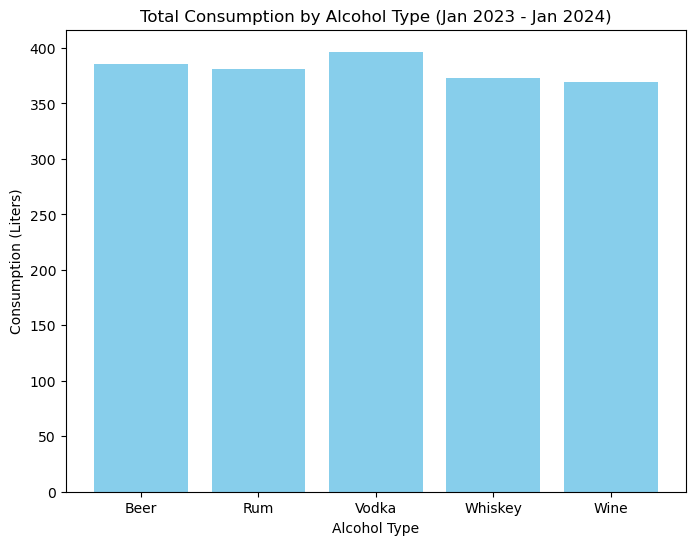

In [39]:
# Visualize total consumption
plt.figure(figsize=(8, 6))
plt.bar(total_consumption["Alcohol Type"], total_consumption["Consumed (ml)"] / 1000, color="skyblue")
plt.title("Total Consumption by Alcohol Type (Jan 2023 - Jan 2024)")
plt.xlabel("Alcohol Type")
plt.ylabel("Consumption (Liters)")
plt.savefig("total_consumption.png")
plt.show()
plt.close() # Close the plot to free memory

In [40]:
# Consumption trends for each bar (daily)
bars = daily_consumption["Bar Name"].unique()
alcohol_types = daily_consumption["Alcohol Type"].unique()
print("Unique Bar Names:")
print(bars)

print("\nUnique Alcohol Types:")
print(alcohol_types)

Unique Bar Names:
["Anderson's Bar" "Brown's Bar" "Johnson's Bar" "Smith's Bar"
 "Taylor's Bar" "Thomas's Bar"]

Unique Alcohol Types:
['Beer' 'Rum' 'Whiskey' 'Wine' 'Vodka']


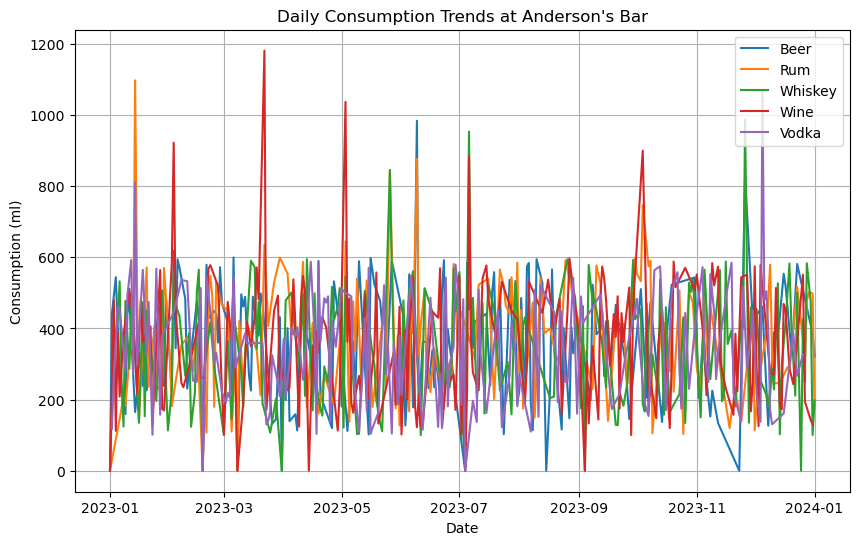

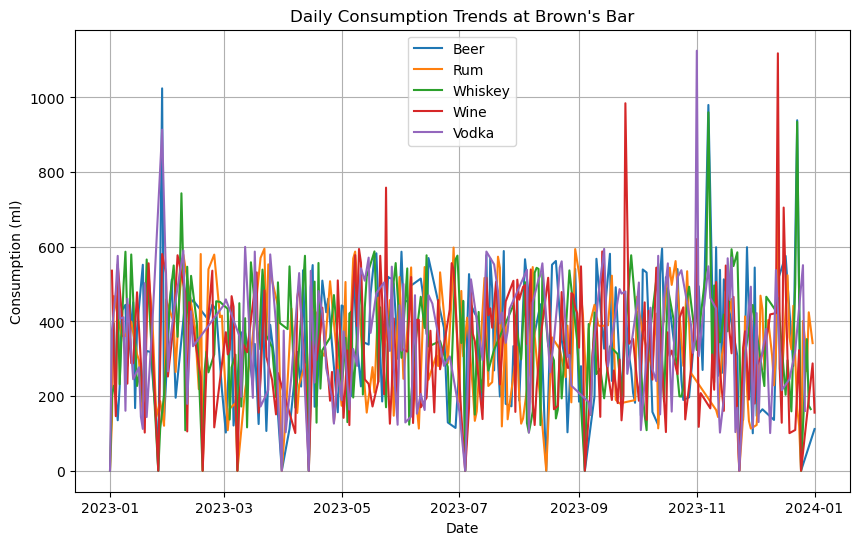

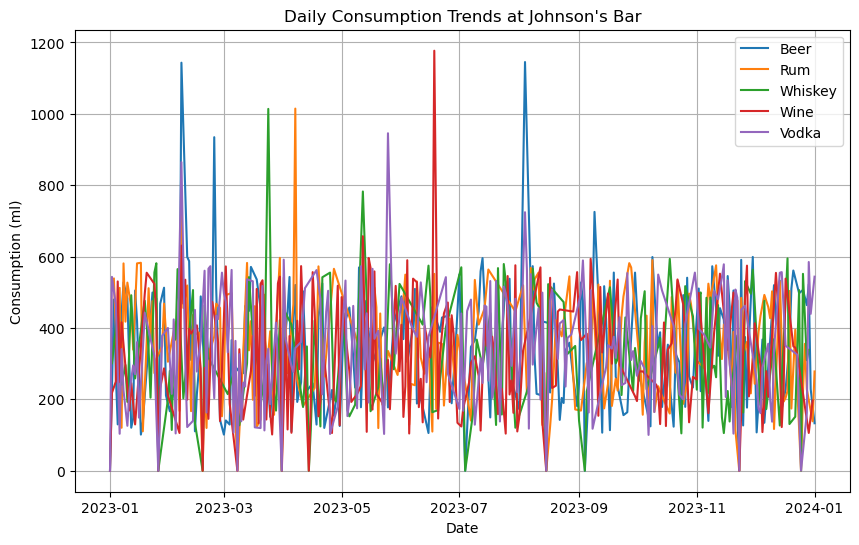

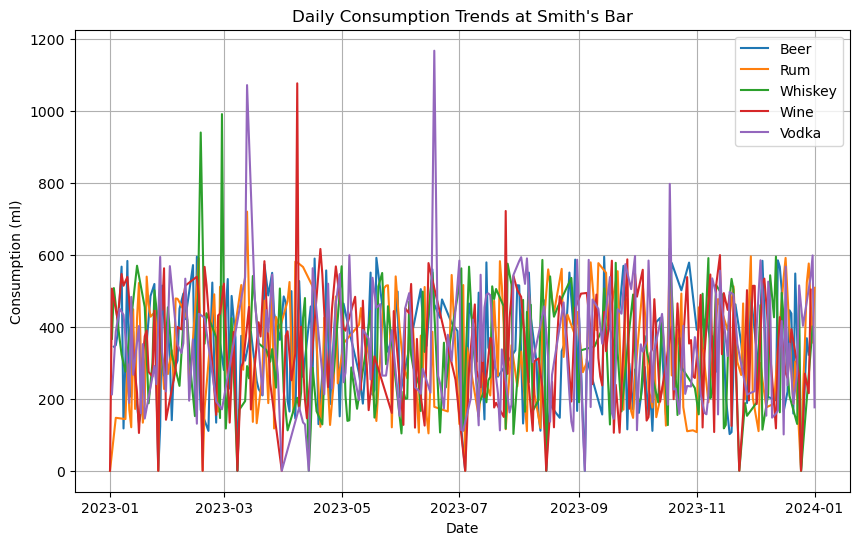

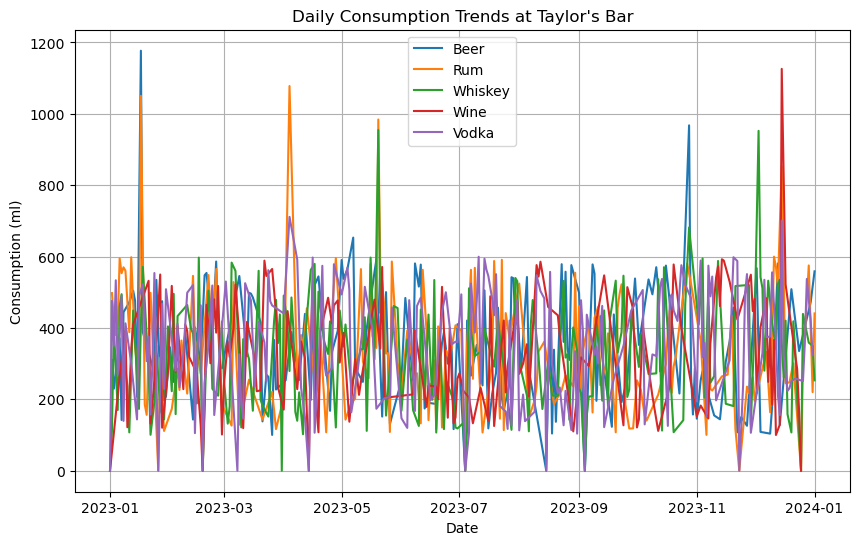

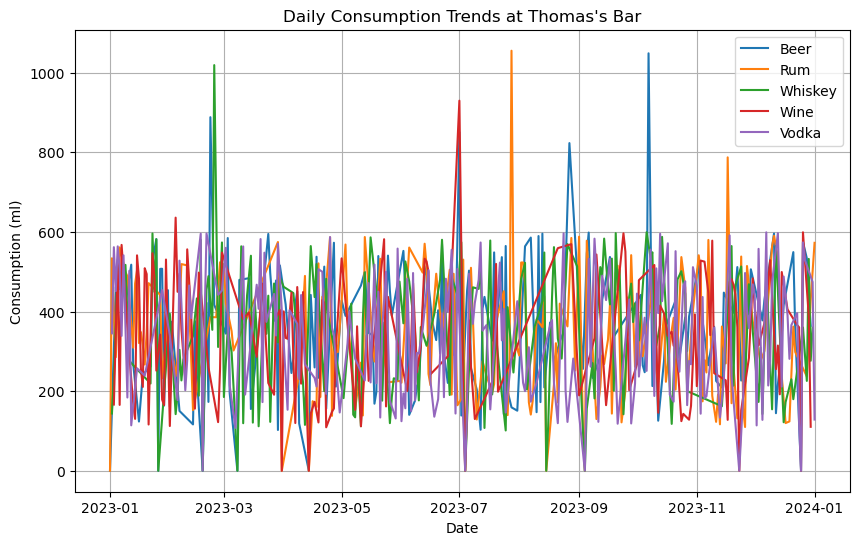

In [41]:
for bar in bars:
    plt.figure(figsize=(10, 6))
    for alcohol in alcohol_types:
        subset = daily_consumption[(daily_consumption["Bar Name"] == bar) & (daily_consumption["Alcohol Type"] == alcohol)]
        plt.plot(subset["Date"], subset["Consumed (ml)"], label=alcohol)
    plt.title(f"Daily Consumption Trends at {bar}")
    plt.xlabel("Date")
    plt.ylabel("Consumption (ml)")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"consumption_trend_{bar.replace(' ', '_')}.png")
    plt.show()
    plt.close()

In [42]:
# Hourly consumption analysis
hourly_consumption = df.groupby(["Bar Name", "Alcohol Type", "Hour"])["Consumed (ml)"].mean().reset_index()
print("Average Hourly Consumption (ml)")
print(hourly_consumption)
print(hourly_consumption["Bar Name"].unique())

Average Hourly Consumption (ml)
           Bar Name Alcohol Type  Hour  Consumed (ml)
0    Anderson's Bar         Beer    10     388.328235
1    Anderson's Bar         Beer    11     378.150000
2    Anderson's Bar         Beer    12     339.584000
3    Anderson's Bar         Beer    13     310.958333
4    Anderson's Bar         Beer    14     400.965000
..              ...          ...   ...            ...
385    Thomas's Bar         Wine    18     394.054000
386    Thomas's Bar         Wine    19     344.914762
387    Thomas's Bar         Wine    20     305.740714
388    Thomas's Bar         Wine    21     291.392222
389    Thomas's Bar         Wine    22     372.493846

[390 rows x 4 columns]
["Anderson's Bar" "Brown's Bar" "Johnson's Bar" "Smith's Bar"
 "Taylor's Bar" "Thomas's Bar"]


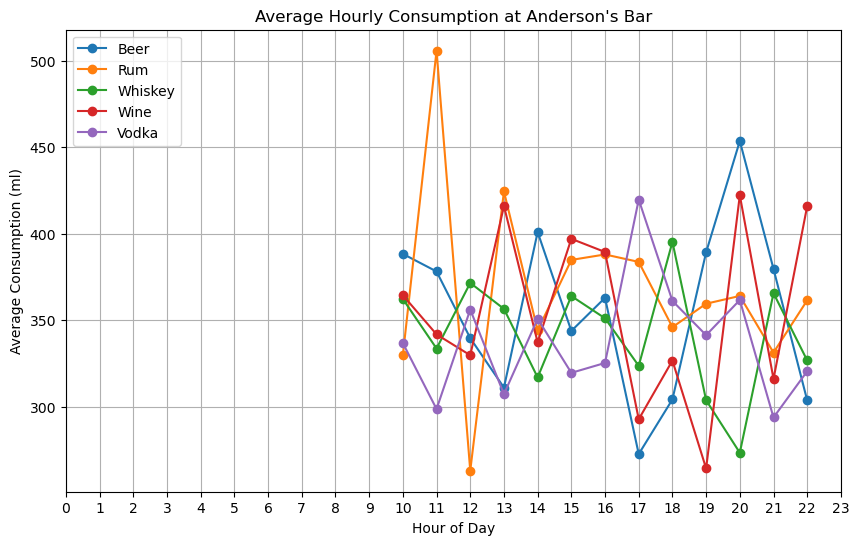

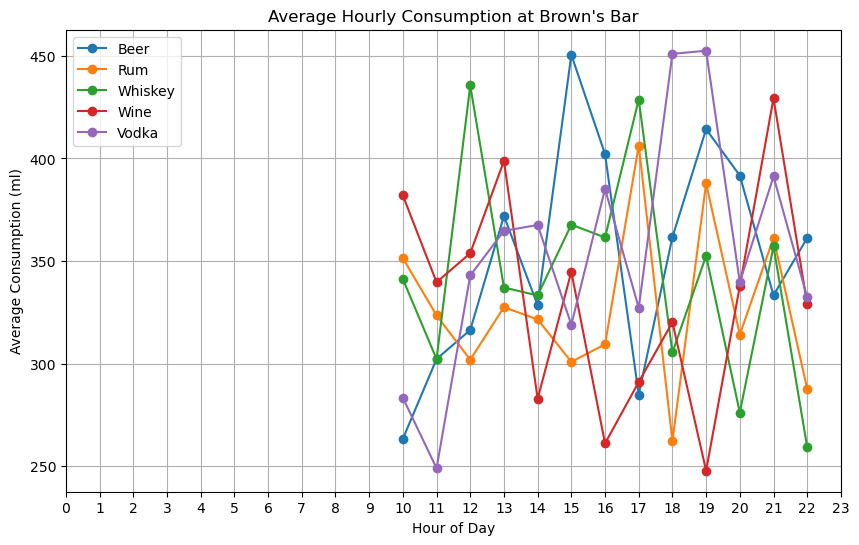

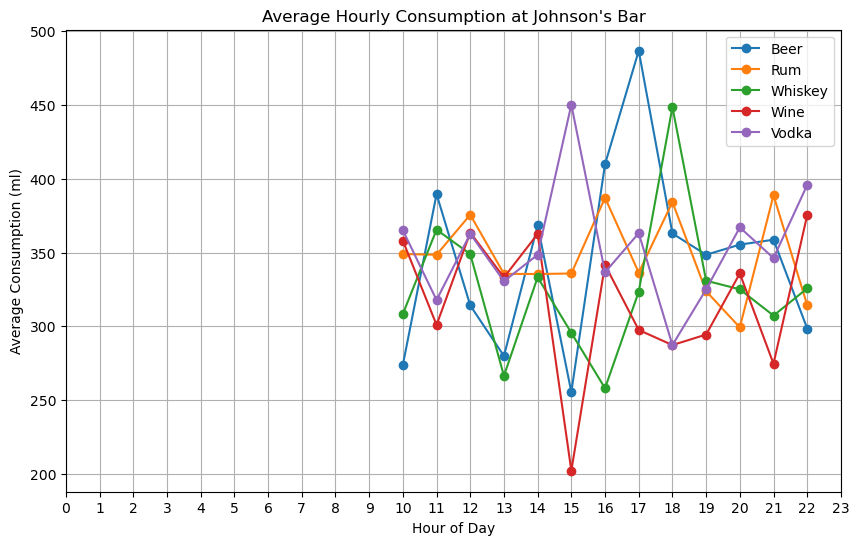

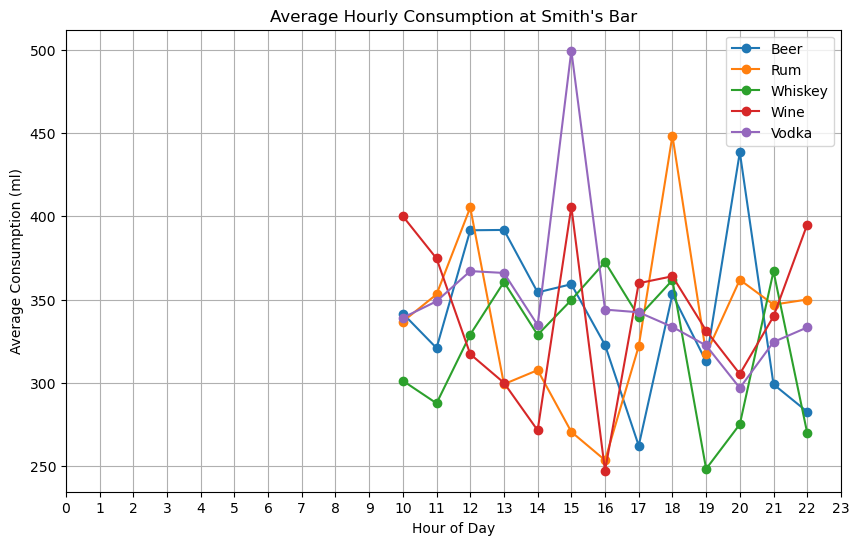

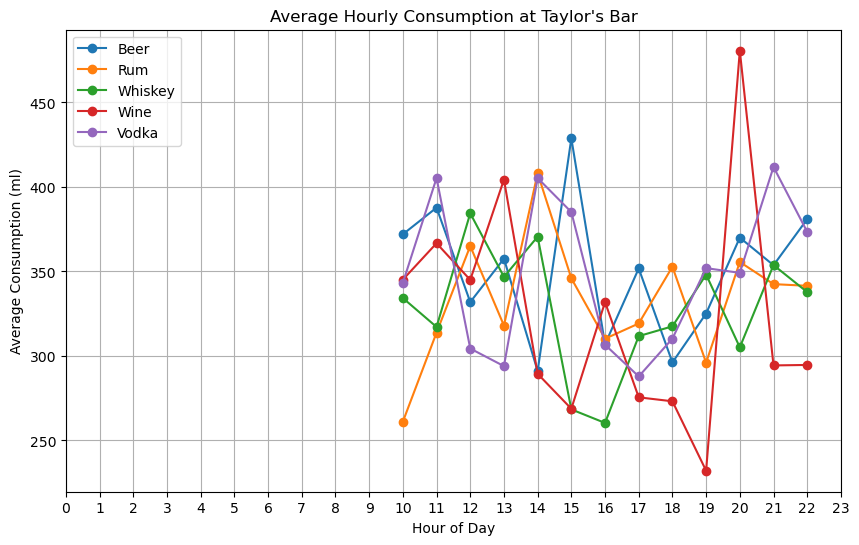

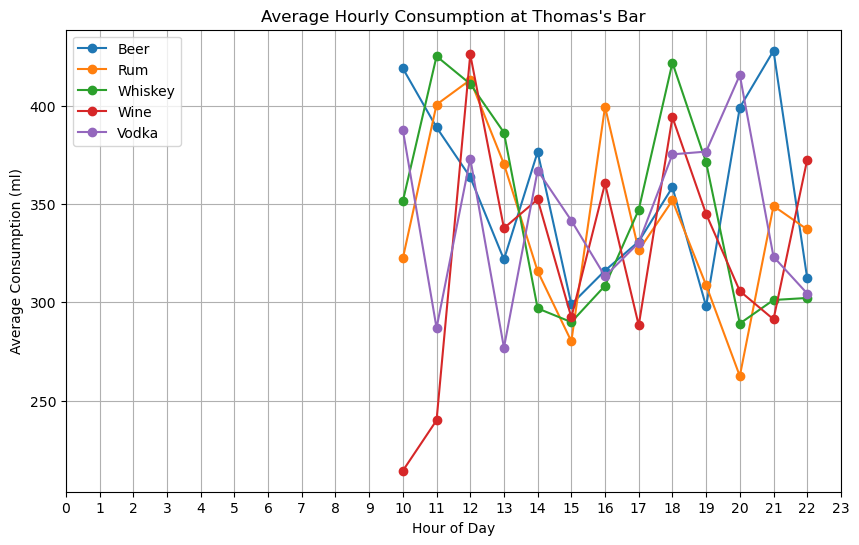

In [43]:
# Visualize hourly consumption
for bar in bars:
    plt.figure(figsize=(10, 6))
    for alcohol in alcohol_types:
        subset = hourly_consumption[(hourly_consumption["Bar Name"] == bar) & (hourly_consumption["Alcohol Type"] == alcohol)]
        if not subset.empty:
            plt.plot(subset["Hour"], subset["Consumed (ml)"], label=alcohol, marker='o')
    plt.title(f"Average Hourly Consumption at {bar}")
    plt.xlabel("Hour of Day")
    plt.ylabel("Average Consumption (ml)")
    plt.legend()
    plt.grid(True)
    plt.xticks(range(0, 24))
    plt.savefig(f"hourly_consumption_{bar.replace(' ', '_')}.png")
    plt.show()
    plt.close()

In [63]:
# Identify peak demand hour for each bar
peak_hours = hourly_consumption.groupby(["Bar Name"])["Consumed (ml)"].idxmax()
peak_hours_data = hourly_consumption.loc[peak_hours, ["Bar Name", "Alcohol Type", "Hour", "Consumed (ml)"]]
print("Peak Demand Hours by Bar")
print(peak_hours_data)

Peak Demand Hours by Bar
           Bar Name Alcohol Type  Hour  Consumed (ml)
14   Anderson's Bar          Rum    11     505.892857
100     Brown's Bar        Vodka    19     452.515455
137   Johnson's Bar         Beer    17     486.870000
226     Smith's Bar        Vodka    15     499.284167
322    Taylor's Bar         Wine    20     480.598000
336    Thomas's Bar         Beer    21     427.839500


In [62]:
# Day of week consumption analysis
daily_consumption_with_day = daily_consumption.merge(
    df[["Date", "Day of Week"]].drop_duplicates(),
    on="Date",
    how="left"
)
day_of_week_consumption = daily_consumption_with_day.groupby(["Bar Name", "Day of Week"])["Consumed (ml)"].mean().reset_index()
print("Average Consumption by Day of Week (ml)")
print(day_of_week_consumption)

Average Consumption by Day of Week (ml)
          Bar Name Day of Week  Consumed (ml)
0   Anderson's Bar      Friday     374.913893
1   Anderson's Bar      Monday     317.973651
2   Anderson's Bar    Saturday     360.770142
3   Anderson's Bar      Sunday     341.854722
4   Anderson's Bar    Thursday     354.738033
5   Anderson's Bar     Tuesday     348.165167
6   Anderson's Bar   Wednesday     365.533957
7      Brown's Bar      Friday     329.925333
8      Brown's Bar      Monday     337.751128
9      Brown's Bar    Saturday     358.400923
10     Brown's Bar      Sunday     336.551618
11     Brown's Bar    Thursday     319.164419
12     Brown's Bar     Tuesday     334.181069
13     Brown's Bar   Wednesday     369.541838
14   Johnson's Bar      Friday     348.552282
15   Johnson's Bar      Monday     313.409714
16   Johnson's Bar    Saturday     315.053869
17   Johnson's Bar      Sunday     353.886296
18   Johnson's Bar    Thursday     350.667237
19   Johnson's Bar     Tuesday     339.1

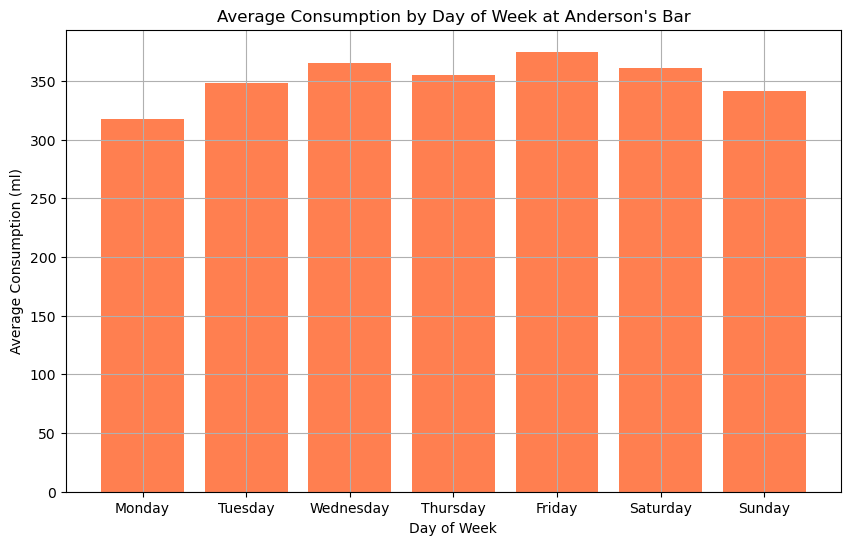

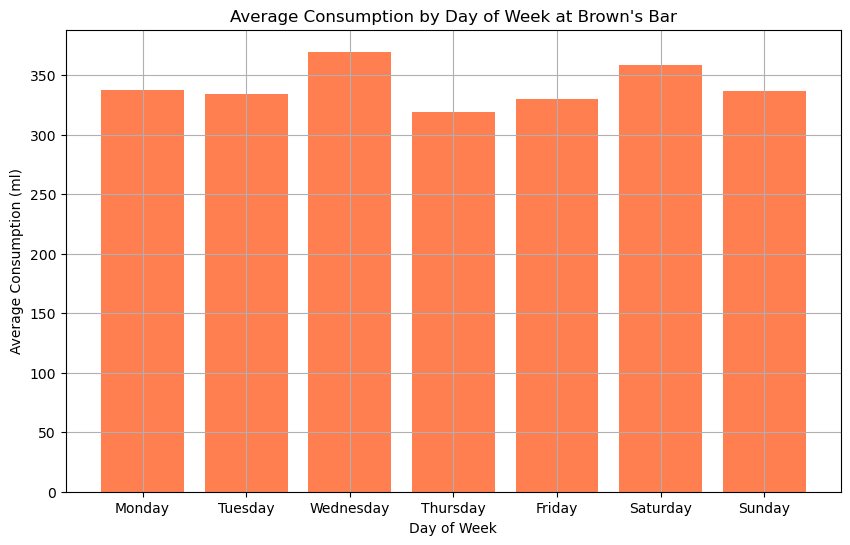

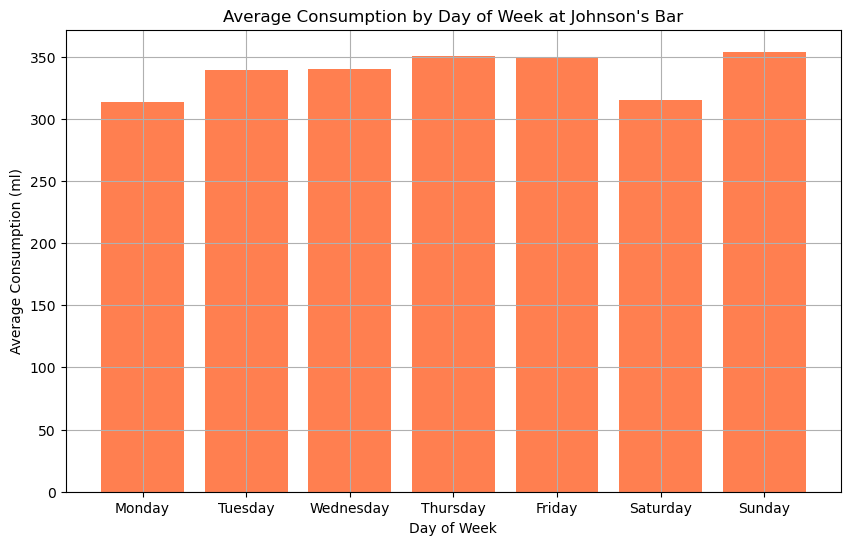

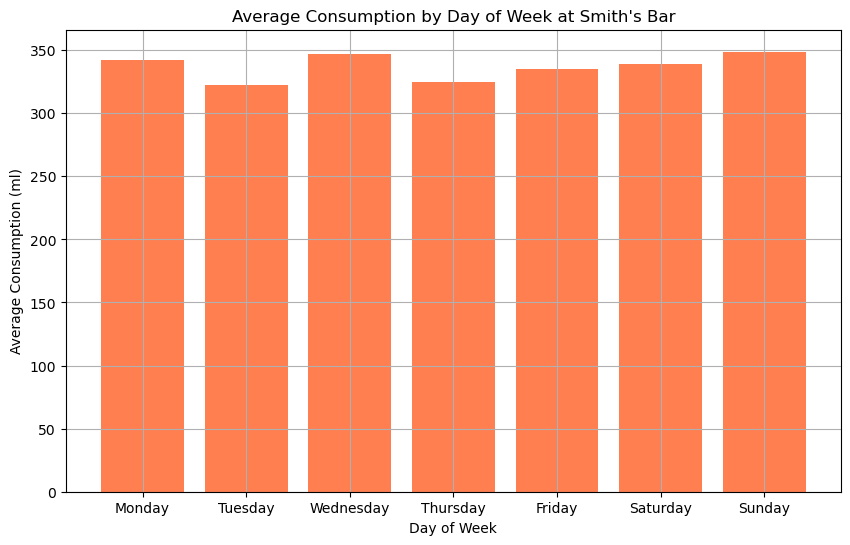

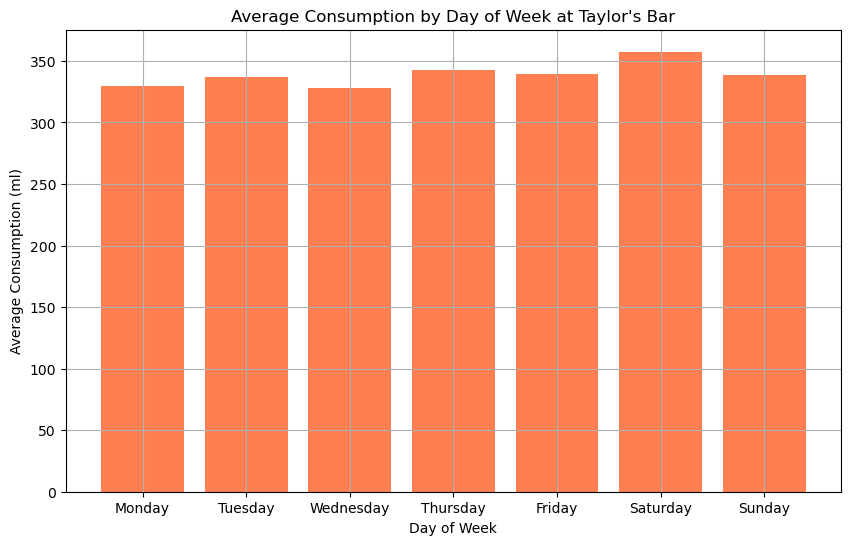

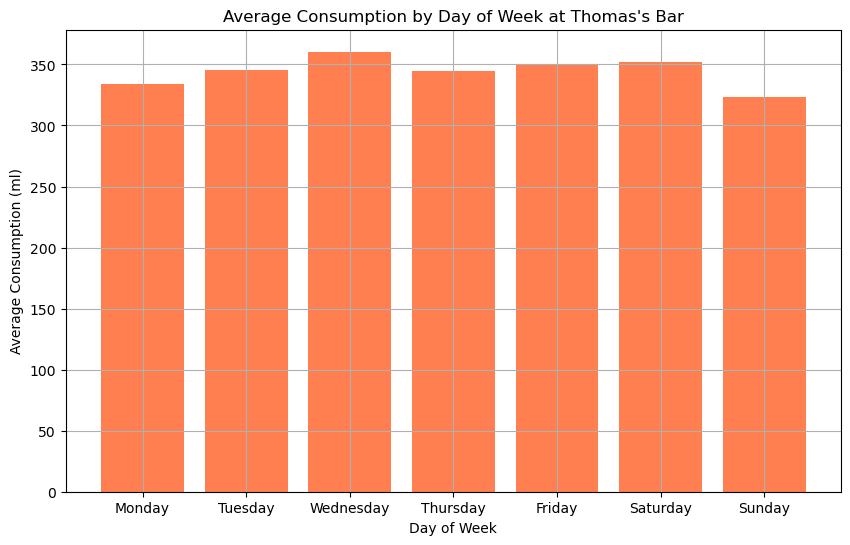

In [46]:
# Visualize day of week consumption
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
for bar in bars:
    plt.figure(figsize=(10, 6))
    subset = day_of_week_consumption[day_of_week_consumption["Bar Name"] == bar]
    if not subset.empty:
        # Ensure days are in correct order
        subset = subset.set_index("Day of Week").reindex(day_order).reset_index()
        plt.bar(subset["Day of Week"], subset["Consumed (ml)"], color="coral")
    plt.title(f"Average Consumption by Day of Week at {bar}")
    plt.xlabel("Day of Week")
    plt.ylabel("Average Consumption (ml)")
    plt.grid(True)
    plt.savefig(f"day_of_week_consumption_{bar.replace(' ', '_')}.png")
    plt.show()
    plt.close()

In [48]:
# Identify peak demand day for each bar
peak_days = day_of_week_consumption.groupby(["Bar Name"])["Consumed (ml)"].idxmax()
peak_days_data = day_of_week_consumption.loc[peak_days, ["Bar Name", "Day of Week", "Consumed (ml)"]]
print("Peak Demand Days by Bar")
print(peak_days_data)

Peak Demand Days by Bar
          Bar Name Day of Week  Consumed (ml)
0   Anderson's Bar      Friday     374.913893
13     Brown's Bar   Wednesday     369.541838
17   Johnson's Bar      Sunday     353.886296
24     Smith's Bar      Sunday     348.776618
30    Taylor's Bar    Saturday     357.460806
41    Thomas's Bar   Wednesday     360.412602


## Step 3: Demand Forecasting with Prophet

In [49]:
# Forecast daily consumption using Prophet for the last 7 days of data.
# Define the time window for forecasting (Dec 25, 2023 - Jan 1, 2024)
end_date = datetime(2024, 1, 1).date()
start_date = end_date - timedelta(days=7)
recent_data = daily_consumption[(daily_consumption["Date"] >= start_date) & (daily_consumption["Date"] <= end_date)]

In [65]:
# Prepare forecast results
forecast_data = []
for bar in bars:
    for alcohol in alcohol_types:
        # Filter data for this bar and alcohol type
        subset = daily_consumption[(daily_consumption["Bar Name"] == bar) & (daily_consumption["Alcohol Type"] == alcohol)]
        if subset.empty:
            continue
        
        # Prepare data for Prophet (requires 'ds' and 'y' columns)
        prophet_df = subset[["Date", "Consumed (ml)"]].rename(columns={"Date": "ds", "Consumed (ml)": "y"})
        prophet_df["ds"] = pd.to_datetime(prophet_df["ds"])
        
        # Initialize and fit Prophet model
        model = Prophet(daily_seasonality=True, yearly_seasonality=False, weekly_seasonality=True)
        model.fit(prophet_df)
        
        # Create future dataframe for the last 7 days
        future = model.make_future_dataframe(periods=7, include_history=False)
        forecast = model.predict(future)
        
        # Extract mean forecast and uncertainty for the last 7 days
        forecast = forecast[forecast["ds"].dt.date >= start_date]
        avg_consumption = forecast["yhat"].mean()
        uncertainty = (forecast["yhat_upper"] - forecast["yhat"]).mean()  # Use upper bound for safety stock
        
        forecast_data.append({
            "Bar Name": bar,
            "Alcohol Type": alcohol,
            "Avg Consumption": avg_consumption,
            "Uncertainty": uncertainty
        })
        
        # Generate a sample forecast plot for the first bar-alcohol combination
        if bar == bars[0] and alcohol == alcohol_types[0]:
            fig = model.plot(forecast)
            plt.title(f"Prophet Forecast for {bar} - {alcohol}")
            plt.savefig(f"prophet_forecast_{bar.replace(' ', '_')}_{alcohol}.png")
            plt.close()

forecast_data = pd.DataFrame(forecast_data)
print("Forecasted Daily Consumption (Last 7 Days, Prophet)")
print(forecast_data)

19:23:53 - cmdstanpy - INFO - Chain [1] start processing
19:23:53 - cmdstanpy - INFO - Chain [1] done processing
19:23:53 - cmdstanpy - INFO - Chain [1] start processing
19:23:53 - cmdstanpy - INFO - Chain [1] done processing
19:23:53 - cmdstanpy - INFO - Chain [1] start processing
19:23:53 - cmdstanpy - INFO - Chain [1] done processing
19:23:53 - cmdstanpy - INFO - Chain [1] start processing
19:23:53 - cmdstanpy - INFO - Chain [1] done processing
19:23:53 - cmdstanpy - INFO - Chain [1] start processing
19:23:54 - cmdstanpy - INFO - Chain [1] done processing
19:23:54 - cmdstanpy - INFO - Chain [1] start processing
19:23:54 - cmdstanpy - INFO - Chain [1] done processing
19:23:54 - cmdstanpy - INFO - Chain [1] start processing
19:23:54 - cmdstanpy - INFO - Chain [1] done processing
19:23:54 - cmdstanpy - INFO - Chain [1] start processing
19:23:54 - cmdstanpy - INFO - Chain [1] done processing
19:23:54 - cmdstanpy - INFO - Chain [1] start processing
19:23:55 - cmdstanpy - INFO - Chain [1]

Forecasted Daily Consumption (Last 7 Days, Prophet)
          Bar Name Alcohol Type  Avg Consumption  Uncertainty
0   Anderson's Bar         Beer       367.080944   212.884830
1   Anderson's Bar          Rum       378.149132   210.849004
2   Anderson's Bar      Whiskey       349.530186   215.014288
3   Anderson's Bar         Wine       364.972877   235.353289
4   Anderson's Bar        Vodka       355.868330   201.705075
5      Brown's Bar         Beer       354.119984   225.072523
6      Brown's Bar          Rum       316.044631   194.093353
7      Brown's Bar      Whiskey       358.970454   215.732958
8      Brown's Bar         Wine       319.110585   217.530526
9      Brown's Bar        Vodka       354.399614   212.798851
10   Johnson's Bar         Beer       356.533700   218.960334
11   Johnson's Bar          Rum       315.714381   196.375679
12   Johnson's Bar      Whiskey       327.506652   211.847042
13   Johnson's Bar         Wine       340.989951   215.293767
14   Johnson's Bar

## Step 4: Inventory Logic (Par Level Recommendation)

In [64]:
# Recommend par levels using Prophet forecasts and uncertainty for safety stock.
lead_time = 3  # Days to restock
safety_factor = 1.5  # Multiplier for uncertainty
forecast_data["Par Level (ml)"] = (forecast_data["Avg Consumption"] * lead_time + 
                                  forecast_data["Uncertainty"] * safety_factor).apply(lambda x: np.ceil(x / 100) * 100)

print("Recommended Par Levels")
print(forecast_data[["Bar Name", "Alcohol Type", "Avg Consumption", "Par Level (ml)"]])

Recommended Par Levels
          Bar Name Alcohol Type  Avg Consumption  Par Level (ml)
0   Anderson's Bar         Beer       367.080944          1500.0
1   Anderson's Bar          Rum       378.149132          1500.0
2   Anderson's Bar      Whiskey       349.530186          1400.0
3   Anderson's Bar         Wine       364.972877          1500.0
4   Anderson's Bar        Vodka       355.868330          1400.0
5      Brown's Bar         Beer       354.119984          1500.0
6      Brown's Bar          Rum       316.044631          1300.0
7      Brown's Bar      Whiskey       358.970454          1400.0
8      Brown's Bar         Wine       319.110585          1300.0
9      Brown's Bar        Vodka       354.399614          1400.0
10   Johnson's Bar         Beer       356.533700          1500.0
11   Johnson's Bar          Rum       315.714381          1300.0
12   Johnson's Bar      Whiskey       327.506652          1400.0
13   Johnson's Bar         Wine       340.989951          1400.0
14

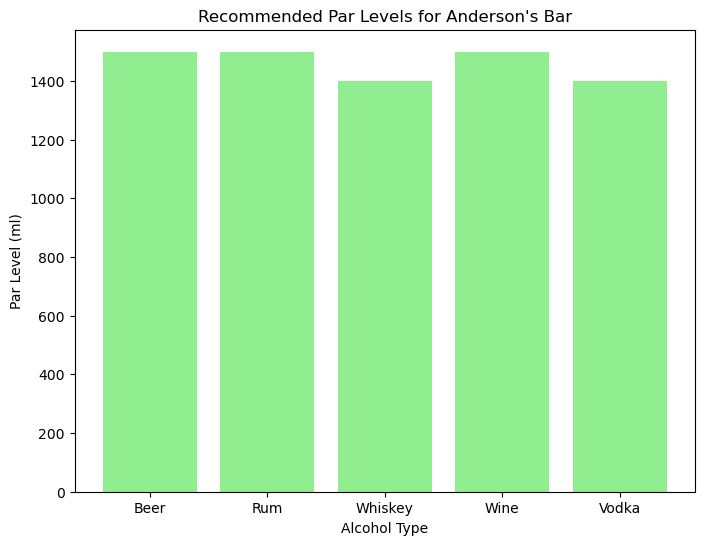

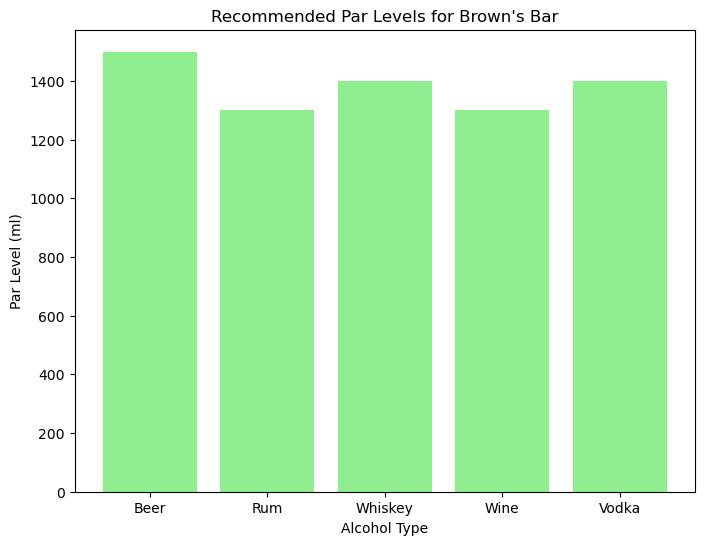

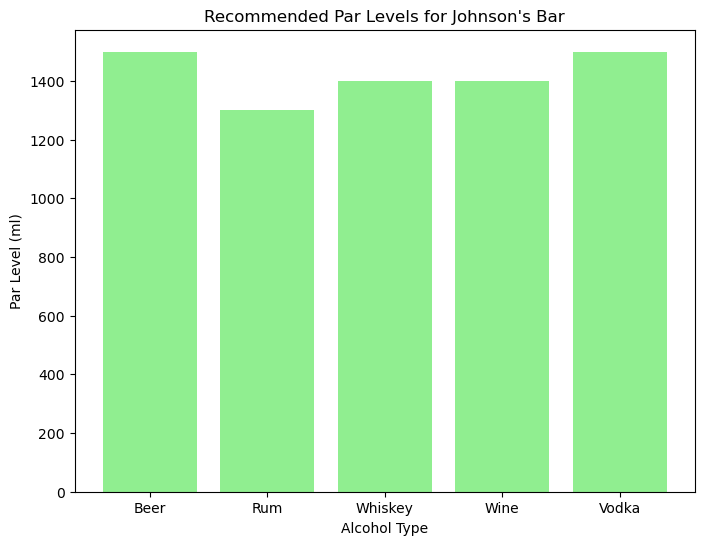

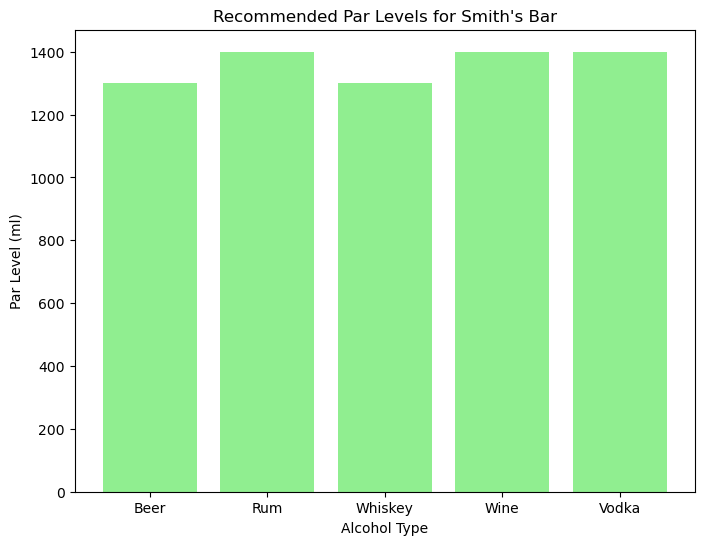

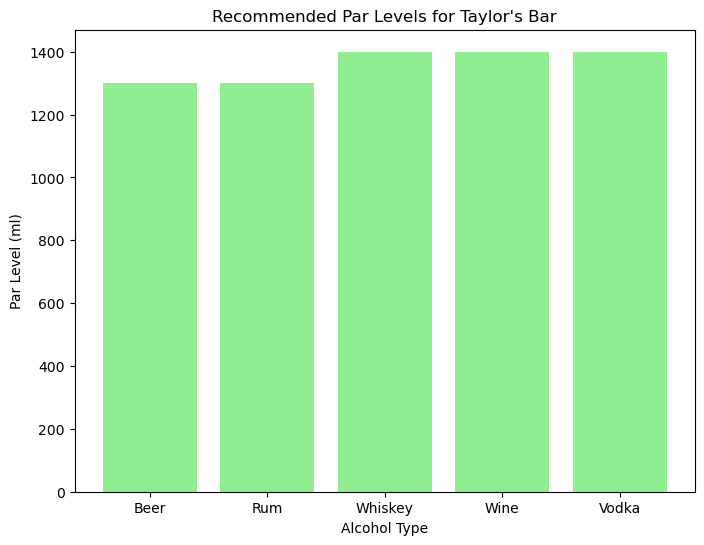

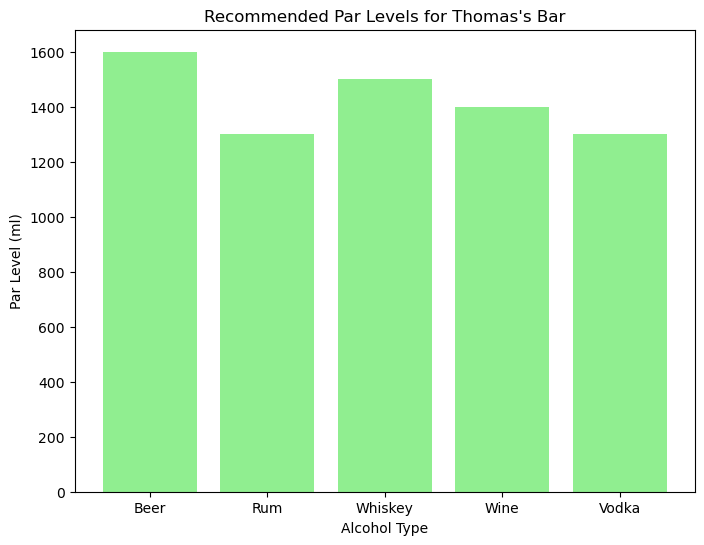

In [54]:
# Visualize par levels
for bar in bars:
    subset = forecast_data[forecast_data["Bar Name"] == bar]
    plt.figure(figsize=(8, 6))
    plt.bar(subset["Alcohol Type"], subset["Par Level (ml)"], color="lightgreen")
    plt.title(f"Recommended Par Levels for {bar}")
    plt.xlabel("Alcohol Type")
    plt.ylabel("Par Level (ml)")
    plt.savefig(f"par_levels_{bar.replace(' ', '_')}.png")
    plt.show()
    plt.close()

## Step 5: Simulation

In [66]:
# Merge closing balances with daily consumption
balances = df.groupby(["Date", "Bar Name", "Alcohol Type"])["Closing Balance (ml)"].sum().reset_index()
simulation_data = recent_data.merge(balances, on=["Date", "Bar Name", "Alcohol Type"], how="left")

In [60]:
# Initialize simulation results
simulation_results = []
for _, row in forecast_data.iterrows():
    bar = row["Bar Name"]
    alcohol = row["Alcohol Type"]
    par_level = row["Par Level (ml)"]
    subset = simulation_data[(simulation_data["Bar Name"] == bar) & (simulation_data["Alcohol Type"] == alcohol)]
    
    # Count stockouts (balance < 100 ml) and overstocks (balance > 2 * par_level)
    stockouts = len(subset[subset["Closing Balance (ml)"] < 100])
    overstocks = len(subset[subset["Closing Balance (ml)"] > 2 * par_level])
    
    simulation_results.append({
        "Bar Name": bar,
        "Alcohol Type": alcohol,
        "Avg Consumption (ml)": row["Avg Consumption"],
        "Par Level (ml)": par_level,
        "Stockouts": stockouts,
        "Overstocks": overstocks
    })

simulation_df = pd.DataFrame(simulation_results)
print("Simulation Results (Last 7 Days)")
print(simulation_df)

Simulation Results (Last 7 Days)
          Bar Name Alcohol Type  Avg Consumption (ml)  Par Level (ml)  \
0   Anderson's Bar         Beer            367.080944          1500.0   
1   Anderson's Bar          Rum            378.149132          1500.0   
2   Anderson's Bar      Whiskey            349.530186          1400.0   
3   Anderson's Bar         Wine            364.972877          1500.0   
4   Anderson's Bar        Vodka            355.868330          1400.0   
5      Brown's Bar         Beer            354.119984          1500.0   
6      Brown's Bar          Rum            316.044631          1300.0   
7      Brown's Bar      Whiskey            358.970454          1400.0   
8      Brown's Bar         Wine            319.110585          1300.0   
9      Brown's Bar        Vodka            354.399614          1400.0   
10   Johnson's Bar         Beer            356.533700          1500.0   
11   Johnson's Bar          Rum            315.714381          1300.0   
12   Johnson's Bar

## Step 6: Interesting Insight

In [61]:
# Identify the alcohol type with the highest variability and peak demand times/days.

forecast_data["Variability Ratio"] = forecast_data["Par Level (ml)"] / (forecast_data["Avg Consumption"] + 1e-10)
most_variable = forecast_data.loc[forecast_data["Variability Ratio"].idxmax()]
print(f"Interesting Insight")
print(f"{most_variable['Bar Name']} has the highest variability for {most_variable['Alcohol Type']}, "
      f"with a par level {most_variable['Variability Ratio']:.2f} times its average consumption. "
      f"This suggests potential demand spikes or data inconsistencies.")

Interesting Insight
Taylor's Bar has the highest variability for Rum, with a par level 4.40 times its average consumption. This suggests potential demand spikes or data inconsistencies.


In [59]:
# Highlight peak demand hours and days
print(f"\nPeak demand hours (e.g., {peak_hours_data.iloc[0]['Hour']}:00 for "
      f"{peak_hours_data.iloc[0]['Alcohol Type']} at {peak_hours_data.iloc[0]['Bar Name']}) and "
      f"peak demand days (e.g., {peak_days_data.iloc[0]['Day of Week']} at {peak_days_data.iloc[0]['Bar Name']}) "
      f"indicate high consumption periods, guiding staffing and restocking schedules.")


Peak demand hours (e.g., 11:00 for Rum at Anderson's Bar) and peak demand days (e.g., Friday at Anderson's Bar) indicate high consumption periods, guiding staffing and restocking schedules.


## Step 7: Conclusion

In [ ]:
# The Prophet-based forecasting system uses `Consumed (ml)` for robust daily demand predictions,
# while `Closing Balance (ml)` enables simulation of stockouts and overstocking. Hourly and day-of-week
# analyses reveal peak demand times and days, enhancing operational planning.
Managers should:
# - Use par levels to guide daily purchase orders.
# - Monitor high-variability items (e.g., {most_variable['Alcohol Type']} at {most_variable['Bar Name']}).